<h1> Feature engineering <br>
Modelling <br>
and Evaluation</h2>
<br>
<br>
<b> This is work in progress! </b> <p> We need to add the deterministic process to the training data. We need to find out how to implement lagged variables, we need to discuss whether,we should use future values as well. 

<ol>
<li>Deterministic process</li>
<li>Lagged variables</li>
<li> Fourier</li>
<li>Seasonal indicators (very important)</li>
<li></li>
<li></li>
<li></li>
</ol>

<h1> 1. Getting started </h1>
<h2> 1.1 Importing libraries </h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import 
from sklearn.compose import ColumnTransformer



import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, Input, callbacks
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation

from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import  CalendarFourier

<h2> 1.2 Downloading data </h2>

In [2]:
df = pd.read_csv('Preprocessed_data.csv')


df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop(['Date', 'Salmon_exp_price'], axis=1, inplace=True)

<h2> 1.3 Splitting data in 3*2

In [3]:
y = df['Salmon_exp_vol']
X = df.loc[:,'FX_EURONOK':]

X_train, X_eval, y_train, y_eval = train_test_split(X,y, 
                                                    test_size=0.2,
                                                    shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, 
                                                test_size=0.5,
                                                shuffle=False)

<h1> 2. Feature engineering </h1>

<h2> 2.1 Manual imputing </h2>

In [45]:
X_train['FX_EURONOK']['2002-10-14'] = 7.34
X_train['FX_EURONOK']['2008-08-04'] = 7.9995
X_train['FX_EURONOK']['2008-08-08'] = 7.9915
X_train['FX_EURONOK']['2008-08-11'] = 7.9975
X_train['FX_EURONOK']['2008-08-18'] = 7.9740

<h2> 2.2 Time dummy and Fourier  </h2>

In [ ]:
def det_process(X):
    fourier0  =  CalendarFourier(freq='A',  order=3)
    fourier1  =  CalendarFourier(freq='6M',  order=3)
    fourier2  =  CalendarFourier(freq='Q',  order=3)

    dp = DeterministicProcess(
        index=X.index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier0,fourier1,fourier2],
        drop=True
    ) 
    dp = dp.in_sample()
    new_X = pd.concat([X,dp], axis=1)
    return new_X
timeDummy = FunctionTransformer(func=det_process)


<h2> 2.3  Column specific engineering </h2>
<h3> 2.3.1 Log transformation </h3>

In [ ]:
def log_transformation(X):
    X = np.log1p(X)
    return X
loger = FunctionTransformer(func=log_transformation)

<h3> 2.3.2 Lagging variables

In [ ]:
shift_cols = ['Salmon_exp_vol', 'Interest_rate', 'Food_index']

def lagged_var(X):
    lags = [[1,2,3,4],[10],[1,5]]
    shift_cols = ['Salmon_exp_vol', 'Interest_rate', 'Food_index']

    lagged_df = pd.DataFrame()
    for n_col in range(0, len(shift_cols),1):
        for n_lag  in range(0,len(lags[n_col]),1):
            # print(lags[n_col][0])
            lagged_df[shift_cols[n_col]+
                      '_lag'+
                      str(lags[n_col][n_lag])] = X[shift_cols[n_col]].shift(lags[n_col][n_lag])
    return pd.concat([X,lagged_df],axis=1)
lagged_var(df)

<h2> 2.4  Z-scoring </h2>

In [46]:
z_scores = StandardScaler()

<h2> 2.5 Reshaping 2d->3d array

In [47]:
def reshaper(X):
    X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])    
    return   X_reshaped
reshape = FunctionTransformer(func=reshaper)
log_cols = ['FX_EURONOK']

<h1> 3. LSTM model </h1>

In [ ]:
model = keras.Sequential([
    layers.LSTM(2, input_shape=(1,74)),
    layers.Dropout(0.4),
    layers.Dense(8, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='adam',
              loss='mae')

early_stopping = callbacks.EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

<h1> 4.  Pipelining </h1>
<h2> 4.1 Column specific pipeline </h2>

In [ ]:
engineering = ColumnTransformer(
    transformers=[
        ('loger', loger, log_cols)      
], remainder='passthrough')

<h2> 4.2 Total pipeline </h2>

In [ ]:
pipe = Pipeline(steps=[
    ('det', timeDummy),
    ('Col_spec', engineering),
    ('norm', z_scores),
    ('res', reshape),
    ('lstm', model)
])

pipe.fit(X_train_preprocessed, y_train, 
          epochs=150, batch_size=50,
          validation_data=[X_val_preprocessed, y_val]
          )

<h1> X. Rest are drafts.. </h1>

In [10]:
X_train_preprocessed =popo.fit_transform(X_train)
X_val_preprocessed = popo.transform(X_val)
X_test_preprocessed = popo.transform(X_test)

In [11]:
X_train_preprocessed.shape

(960, 1, 74)

In [12]:
mod.fit(X_train_preprocessed, y_train, 
          epochs=150, batch_size=50,
          validation_data=[X_val_preprocessed, y_val]
          )

Epoch 1/150
20/20 [==============================] - 2s 21ms/step - loss: 11604.8926 - val_loss: 18467.9551
Epoch 2/150
20/20 [==============================] - 0s 3ms/step - loss: 11604.4336 - val_loss: 18467.7949
Epoch 3/150
20/20 [==============================] - 0s 3ms/step - loss: 11603.8320 - val_loss: 18467.5938
Epoch 4/150
20/20 [==============================] - 0s 3ms/step - loss: 11603.1299 - val_loss: 18467.3223
Epoch 5/150
20/20 [==============================] - 0s 4ms/step - loss: 11602.1475 - val_loss: 18466.9629
Epoch 6/150
20/20 [==============================] - 0s 4ms/step - loss: 11600.8857 - val_loss: 18466.4590
Epoch 7/150
20/20 [==============================] - 0s 4ms/step - loss: 11599.4102 - val_loss: 18465.7617
Epoch 8/150
20/20 [==============================] - 0s 4ms/step - loss: 11597.3662 - val_loss: 18464.7520
Epoch 9/150
20/20 [==============================] - 0s 3ms/step - loss: 11595.0352 - val_loss: 18463.3965
Epoch 10/150
20/20 [================

4/4 [==============================] - 0s 2ms/step


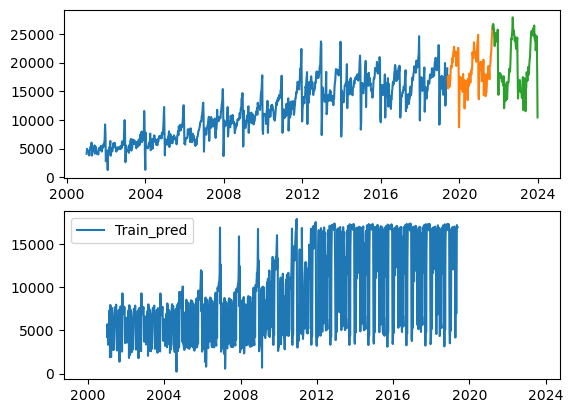

In [13]:
train_pred = mod.predict(X_train_preprocessed)
val_pred = mod.predict(X_test_preprocessed)
# test_pred = mod.predict(X_test_preprocessed)


fig,ax = plt.subplots(2)
ax[0].plot(y_train, label='Train')
ax[0].plot(y_val, label='Valid')
ax[0].plot(y_test, label='Test')

ax[1].plot(X_train.index, train_pred, label='Train_pred')
ax[1].set_xlim(10500,20000)
# ax[1].plot(X_val.index, test_pred, label='Test_pred')

plt.legend()
plt.show()

In [14]:
from sklearn.metrics import root_mean_squared_error as RMSE

In [15]:
RMSE(train_pred, y_train)

4611.131387576781

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)